In [1]:
import os
import numpy as np

from tensorflow import keras
from matplotlib import pyplot as plt

save_dir = "data/CamVid/np_saves/256_256/"

### Load the pretrainned model as well as saved numpy array

In [2]:
model = keras.models.load_model("saved_models/256_256_model")

2022-03-23 16:26:27.717529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 16:26:27.860202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 16:26:27.861036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 16:26:27.867909: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [3]:
X_test = np.load(save_dir + "/x_test.npy")
Y_test = np.load(save_dir+"/y_test.npy")

### Make predictions

In [4]:
Y_predicted = np.argmax(model.predict(X_test, batch_size=4), axis=3)

2022-03-23 16:26:39.523949: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-23 16:26:41.470752: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-03-23 16:26:43.778456: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-23 16:26:43.779015: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-23 16:26:43.779037: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-03-23 16:26:43.779414: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-23 16:26:43.779499: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx co

In [5]:
X_test.shape

(141, 256, 256, 3)

### Import the color-labels

In [12]:
import re

def parse_code(l):
    a,b = re.split('\\t+', l)  # - splits on one or more subsequent tabs, should they occur
    return tuple(int(o) for o in a.split(' ')), b[:-1]  # - [:-1] leaves out the newline at the end of each line

label_codes, labels = zip(*[
    parse_code(l) for l in open("data/CamVid/labels_color.txt")
])

id2code = {index:v for index,v in enumerate(label_codes)}


print(id2code)

{0: (128, 128, 128), 1: (128, 0, 0), 2: (192, 192, 128), 3: (128, 64, 128), 4: (0, 0, 192), 5: (128, 128, 0), 6: (192, 128, 128), 7: (64, 64, 128), 8: (64, 0, 128), 9: (64, 64, 0), 10: (0, 128, 192), 11: (0, 0, 0)}


### Generate RGB ndim array from the given label matrix by mapping each label to it's color

In [13]:
def decode_segmentation_masks(mask, color_mapping):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    
    for class_id, class_color in color_mapping.items():
        idx = mask == class_id
        r[idx] = class_color[0]
        g[idx] = class_color[1]
        b[idx] = class_color[2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


### Visualize the colored image

In [14]:
def visualize_np_array(array):
    from matplotlib import pyplot as plt
    plt.imshow(array, interpolation='nearest')
    plt.show()

# Just print out what colors mean
for i, label in enumerate(labels):
    print(label, id2code[i])

Sky (128, 128, 128)
Building (128, 0, 0)
Column_Pole (192, 192, 128)
Road (128, 64, 128)
Sidewalk (0, 0, 192)
Tree (128, 128, 0)
Sign (192, 128, 128)
Fence (64, 64, 128)
Car (64, 0, 128)
Pedestrian (64, 64, 0)
Bicyclist (0, 128, 192)
Void (0, 0, 0)


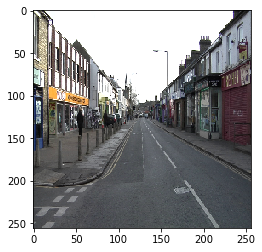

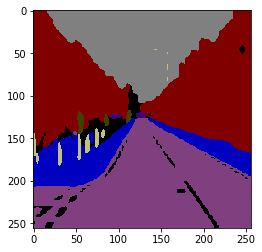

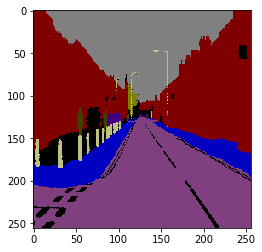

In [15]:
# Display actual image, predicted, and ground truth
image_index = 3
visualize_np_array(X_test[image_index])
visualize_np_array(decode_segmentation_masks(Y_predicted[image_index], id2code))
visualize_np_array(decode_segmentation_masks(Y_test[image_index], id2code))

In [16]:
### Metrics computations


In [17]:
# Global Accuracy

np.sum(Y_test==Y_predicted)/np.size(Y_test)

0.901844322258699

In [18]:
# IoUT
import tensorflow as tf

m = tf.keras.metrics.MeanIoU(num_classes=12)
m.update_state(Y_test, Y_predicted)
m.result().numpy()

0.64455825

### Confusion matrix

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [20]:
cm = confusion_matrix(Y_test.flatten(), Y_predicted.flatten(), normalize='true')


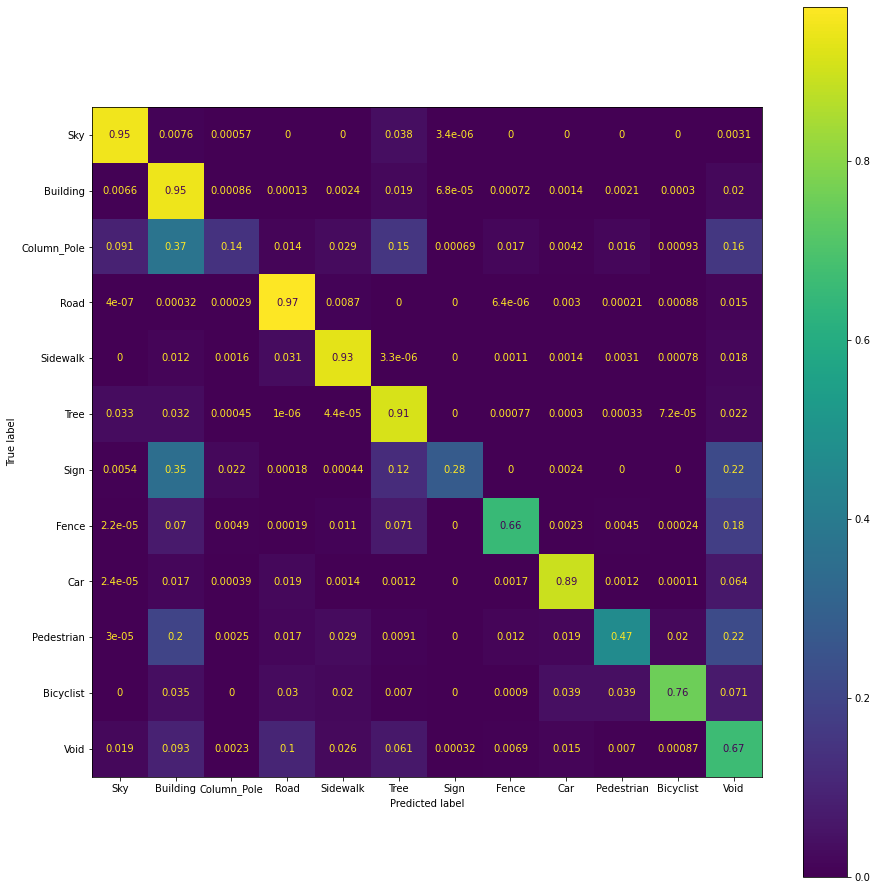

In [21]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(15,16))
disp.plot(ax=ax)

### Classification Report

In [22]:
from sklearn.metrics import classification_report

In [23]:
cr = classification_report(Y_test.flatten(), Y_predicted.flatten(), target_names=labels)

In [24]:
print(cr)

              precision    recall  f1-score   support

         Sky       0.95      0.95      0.95   1457420
    Building       0.90      0.95      0.92   2029041
 Column_Pole       0.61      0.14      0.23     88443
        Road       0.95      0.97      0.96   2508958
    Sidewalk       0.91      0.93      0.92    599211
        Tree       0.84      0.91      0.87    997327
        Sign       0.86      0.28      0.42     11290
       Fence       0.88      0.66      0.75    138833
         Car       0.92      0.89      0.91    368144
  Pedestrian       0.64      0.47      0.54     65809
   Bicyclist       0.85      0.76      0.80     43540
        Void       0.76      0.67      0.71    932560

    accuracy                           0.90   9240576
   macro avg       0.84      0.71      0.75   9240576
weighted avg       0.90      0.90      0.90   9240576



### Plot training acurve

<module 'matplotlib.pyplot' from '/home/vuran/prashant/.conda/envs/tensorflow-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

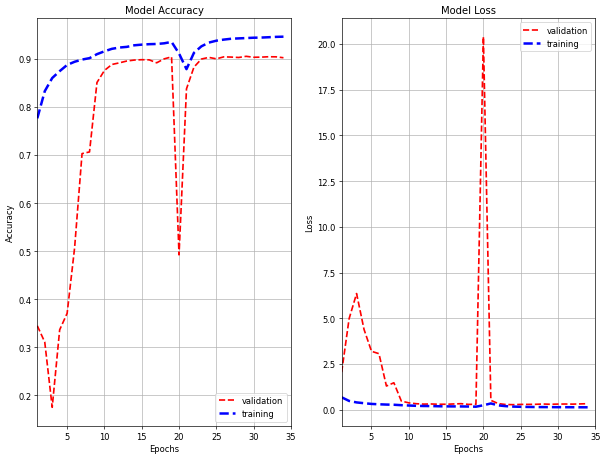

In [27]:
import json

def plot_trainning_history(history):
    epochs=len(history["loss"])
    plt.figure(figsize=(12,9), dpi=60)

    for i, metric in enumerate(["accuracy", "loss"]):
        plt.subplot(1, 2, i+1)

        plt.plot(range(1,epochs+1), history[f'val_{metric}'],"r--", alpha=1.0, linewidth=2.0,label='validation')
        plt.plot(range(1,epochs+1), history[metric],"b--", alpha=1.0, linewidth=3.0,label='training')
        plt.legend(loc=0)
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.xlim([1,epochs+1])
        plt.grid(True)
        plt.title(f"Model {metric.capitalize()}")

    return plt

with open("histories/256_256_model.json") as f:
    history = json.load(f)
    
plot_trainning_history(history)